# Walkthrough of Omega Lokta-Volterra Implementation 

In [1]:
## Load Packages
using Omega
using StatsBase
using Random
using Plots
using Distributions


Internal error: encountered unexpected error in runtime:
rec_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\stackwalk.c:94
record_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:246
jl_throw at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:577
jl_bounds_error_ints at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\rtutils.c:187
getindex at .\array.jl:731
jfptr_getindex_2272.clone_1 at C:\Users\Devon Kohler\AppData\Local\Julia-1.0.5\lib\julia\sys.dll (unknown line)
jl_apply_generic at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\gf.c:2162
replace_code_newstyle! at .\compiler/ssair\legacy.jl:86

## Main Functions

In [2]:
function one_simulation_prey(rng, n, transitions)

    """
    Simulates one step of gillespie for prey. Takes generated hazards
    adds it to prey and outputs the new value.
    
    args:
        rng(): julia base random number generator, do not need to explicitly pass
        n(int): An index to the current step in prey and pred lists. Used to pull
                most recent values for calculations
        transitions: Matrix that determines how much prey/pred should change based
                    on selected hazard
    """

    #t = t_list[n](rng)
    hazard_result = hazards_list[n](rng)
    prey_val = prey_list[n](rng)
    labels = ["spawn_prey", "pred_dies","prey2pred"]
    transition = transitions[labels[hazard_result]]
    new_prey = prey_val + transition[1]

    # Enforce only positive integers
    max(1, new_prey)

end

function one_simulation_pred(rng, n, transitions)

    """
    Simulates one step of gillespie for pred. Takes generated hazards
    adds it to pred and outputs the new value.
    
    args:
        rng(): julia base random number generator, do not need to explicitly pass
        n(int): An index to the current step in prey and pred lists. Used to pull
                most recent values for calculations
        transitions: Matrix that determines how much prey/pred should change based
                    on selected hazard
    """

    #t = t_list[n](rng)
    hazard_result = hazards_list[n](rng)
    pred_val = pred_list[n](rng)
    labels = ["spawn_prey", "pred_dies","prey2pred"]
    transition = transitions[labels[hazard_result]]
    new_pred = pred_val + transition[2]

    # Enforce only positive integers
    max(1, new_pred)

end

function get_hazards(rng, n)
    """
    Compute the hazard function given the current states. "spawn_prey" represents 
    the event of a prey being born, "prey2pred" represents a predator consuming 
    a new prey and consequently spawning a new predator, "pred_dies" represents 
    the death of a predator. The function probabilistically selects one of these 
    based on their weights.

    args:
        rng(): julia base random number generator, do not need to explicitly pass
        n(int): An index to the current step in prey and pred lists. Used to pull
                most recent values for calculations
    """

    ecology = Dict("prey" => prey_list[n](rng), "pred" => pred_list[n](rng))

    hazards = Dict(
        "spawn_prey" => theta(rng)["spawn_prey"] * ecology["prey"],
        "prey2pred" => theta(rng)["prey2pred"] * ecology["prey"] * ecology["pred"],
        "pred_dies" => theta(rng)["pred_dies"] * ecology["pred"]
        )

    vals = collect(values(hazards))
    sum_vals = sum(vals)
    prob_vals = vals/sum_vals
    categorical(rng, prob_vals)
end


get_hazards (generic function with 1 method)

In [3]:
function generate_rates(rng)
    
    """
    Creates a dictionary with rates needed to calculate hazards. Created in 
    a single function so that rates are only generated once and then used
    for the entire simulation.
    """
    
    Dict("spawn_prey" => spawn_prey(rng),
         "prey2pred" => prey2pred(rng),
         "pred_dies" => pred_dies(rng))

end


generate_rates (generic function with 1 method)

## Build Simulation

### Initalize Parameters

In [4]:
## Initialize paramters
Pre = [[1, 0], [1, 1], [0, 1]]
Post = [[2, 0], [0, 2], [0, 0]]
transition_mat = Post - Pre
transitions = Dict("spawn_prey" => transition_mat[1,],
                    "prey2pred" => transition_mat[2,],
                    "pred_dies" => transition_mat[3,])


Dict{String,Array{Int64,1}} with 3 entries:
  "spawn_prey" => [1, 0]
  "pred_dies"  => [0, -1]
  "prey2pred"  => [-1, 1]

Rates and starting values determine the entire trajectory of the simulation. The lower trajectory was used to recreate the plots in the Omega paper. The higher gives better visualization for this specific simulation (can see the stochasiticity better). There could be some arguement whether the rates should be random variables, but we created them that way here in order to test conditionals and interventions.

In [5]:
#t0=0.0

# Random variables for small cycles
# prey_init = normal(10., .001)
# pred_init = normal(10., .001)

# # Random variables for rates
# spawn_prey = normal(1.5, .01)
# prey2pred = normal(1.0, .0001)
# pred_dies = normal(3.0, .0075)

# Random variables for large cycles
prey_init = normal(50., .001)
pred_init = normal(100., .001)

# Random variables for rates
spawn_prey = normal(.9, .01)
prey2pred = normal(.004, .0001)
pred_dies = normal(.4, .0075)

Random.seed!(1234)
theta = ciid(generate_rates)

6:generate_rates()::Any

### Generate Random Var List (Passed to rand function)

In [6]:
## Initialize lists and add starting rand vars
hazards_list = Any[]
prey_list = Any[]
pred_list = Any[]
push!(prey_list, prey_init)
push!(pred_list, pred_init)

## How many time periods to cycle over
N = 5000 

## Create a prey/pred/hazard for each time period
for f in 2:N
    last = f - 1
    hazards_temp = ciid(get_hazards, last) # individual step
    prey_temp = ciid(one_simulation_prey, last, transitions) # individual step
    pred_temp = ciid(one_simulation_pred, last, transitions) # individual step
    push!(hazards_list, hazards_temp)
    push!(prey_list, prey_temp)
    push!(pred_list, pred_temp)
end

## Convert lists to single tuple
random_var_tuple = (Tuple(x for x in hazards_list)...,
                Tuple(x for x in prey_list)...,
                Tuple(x for x in pred_list)...,
                Tuple(Any[spawn_prey,prey2pred,pred_dies,theta])...)
print()

## Simulations

### Simple Simulation

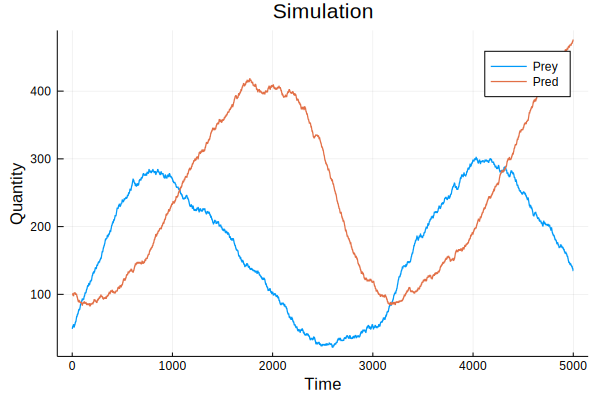

In [7]:
## Sample
Random.seed!(1234) ## Must initialize seed each time if run line by line
samples = rand(random_var_tuple, 1, alg = RejectionSample)

# extract run results and plot
prey_vals = []
pred_vals = []
for x in 1:(N-1)
    push!(prey_vals,samples[1][N+x])
    push!(pred_vals,samples[1][(N*2)+x])
end

plot(hcat(prey_vals,pred_vals),
        title = "Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["Prey" "Pred"],
        lw = 1.25)


### Conditional Simulation

#### Recreate Model with Conditional Rand Vars

If model needs to condition on multiple values this is the easiest way to execute it. A single conditional can simply be passed to the rand function.

In [8]:
## Initialize lists and add starting rand vars
hazards_list = Any[]
prey_list = Any[]
pred_list = Any[]

push!(prey_list, prey_init)
push!(pred_list, pred_init)

## How many time periods to cycle over
N = 5000 

## Indices to condition on
condition_index = 1000:1250

## Create a prey/pred/hazard for each time period
for f in 2:N
    last = f - 1
    hazards_temp = ciid(get_hazards, last) # individual step
    
    ## Condition on prey in this example
    if f in condition_index
        prey_temp_ = ciid(one_simulation_prey, last, transitions)
        prey_temp = cond(prey_temp_, prey_temp_ > 300) ## Conditional
    else
        prey_temp = ciid(one_simulation_prey, last, transitions)
    end
    
    pred_temp = ciid(one_simulation_pred, last, transitions) # individual step

    push!(hazards_list, hazards_temp)
    push!(prey_list, prey_temp)
    push!(pred_list, pred_temp)
end

random_var_tuple = (Tuple(x for x in hazards_list)...,
                Tuple(x for x in prey_list)...,
                Tuple(x for x in pred_list)...,
                Tuple(Any[spawn_prey,prey2pred,pred_dies,theta])...)
print()

(15008:Omega.reifyapply(get_hazards, 1)::Any, 15011:Omega.reifyapply(get_hazards, 2)::Any, 15014:Omega.reifyapply(get_hazards, 3)::Any, 15017:Omega.reifyapply(get_hazards, 4)::Any, 15020:Omega.reifyapply(get_hazards, 5)::Any, 15023:Omega.reifyapply(get_hazards, 6)::Any, 15026:Omega.reifyapply(get_hazards, 7)::Any, 15029:Omega.reifyapply(get_hazards, 8)::Any, 15032:Omega.reifyapply(get_hazards, 9)::Any, 15035:Omega.reifyapply(get_hazards, 10)::Any, 15038:Omega.reifyapply(get_hazards, 11)::Any, 15041:Omega.reifyapply(get_hazards, 12)::Any, 15044:Omega.reifyapply(get_hazards, 13)::Any, 15047:Omega.reifyapply(get_hazards, 14)::Any, 15050:Omega.reifyapply(get_hazards, 15)::Any, 15053:Omega.reifyapply(get_hazards, 16)::Any, 15056:Omega.reifyapply(get_hazards, 17)::Any, 15059:Omega.reifyapply(get_hazards, 18)::Any, 15062:Omega.reifyapply(get_hazards, 19)::Any, 15065:Omega.reifyapply(get_hazards, 20)::Any, 15068:Omega.reifyapply(get_hazards, 21)::Any, 15071:Omega.reifyapply(get_hazards, 22)::A

Internal error: encountered unexpected error in runtime:
StackOverflowError()


In conditionals using the rejection sampling algorithm is dangerous. If conditional is too restrictive, can run forever. An alternative to this is to use the soft execution and a different algorithm (SSMH/NUTS) built into Omega.

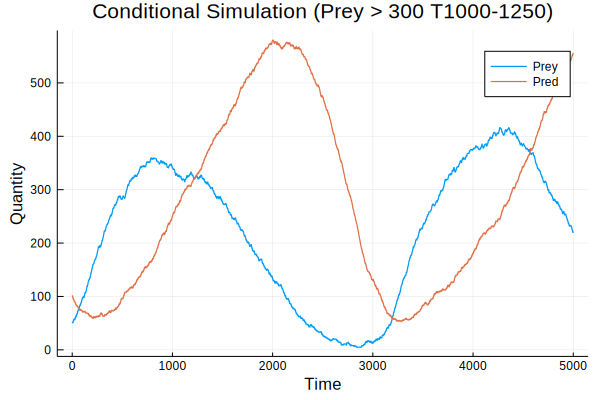

In [10]:
Random.seed!(1234)
samples = rand(random_var_tuple,
                1, alg = RejectionSample)

# extract run results and plot
prey_vals = []
pred_vals = []
for x in 1:(N-1)
    push!(prey_vals,samples[1][N+x])
    push!(pred_vals,samples[1][(N*2)+x])
end

plot(hcat(prey_vals,pred_vals),
        title = "Conditional Simulation (Prey > 300 T1000-1250)",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["Prey" "Pred"],
        lw = 1.25)


### Intervention/Counterfactual

#### Recreate Original Model

In [20]:
## Initialize lists and add starting rand vars
hazards_list = Any[]
prey_list = Any[]
pred_list = Any[]
push!(prey_list, prey_init)
push!(pred_list, pred_init)

## How many time periods to cycle over
N = 5000

## Create a prey/pred/hazard for each time period
for f in 2:N
    last = f - 1
    hazards_temp = ciid(get_hazards, last) # individual step
    prey_temp = ciid(one_simulation_prey, last, transitions) # individual step
    pred_temp = ciid(one_simulation_pred, last, transitions) # individual step
    push!(hazards_list, hazards_temp)
    push!(prey_list, prey_temp)
    push!(pred_list, pred_temp)
end

## Convert lists to single tuple
random_var_tuple = (Tuple(x for x in hazards_list)...,
                Tuple(x for x in prey_list)...,
                Tuple(x for x in pred_list)...,
                Tuple(Any[spawn_prey,prey2pred,pred_dies,theta])...)
print()

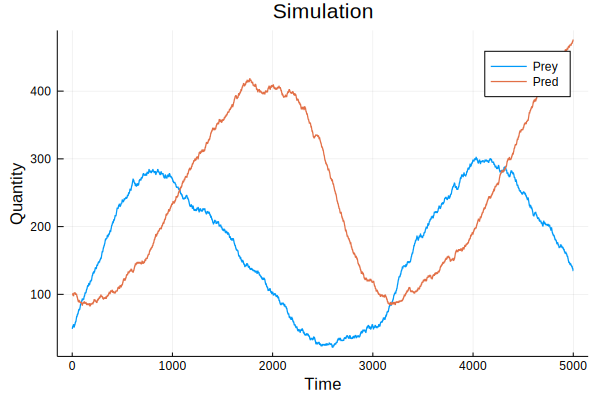

In [21]:
## Original Sim
Random.seed!(1234)
samples = rand(random_var_tuple, 1, alg = RejectionSample)

# extract run results and plot
prey_vals = []
pred_vals = []
for x in 1:(N-1)
    push!(prey_vals,samples[1][N+x])
    push!(pred_vals,samples[1][(N*2)+x])
end

plot(hcat(prey_vals,pred_vals),
        title = "Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["Prey" "Pred"],
        lw = 1.25)


### Intervene by increasing prey early

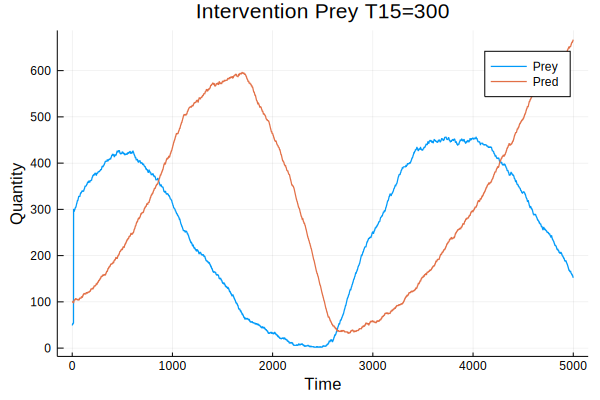

In [22]:
## Make intervention and replace rand var with intervention var
replace_index = 15
new_prey = replace(prey_list[replace_index],
                    prey_list[replace_index - 1] => 300.0)
prey_list_replace = prey_list
prey_list_replace[replace_index] = new_prey ## Replace with intervention

## Run sim as normal after intervention
random_var_tuple_int = (Tuple(x for x in hazards_list)...,
                Tuple(x for x in prey_list_replace)...,
                Tuple(x for x in pred_list)...,
                Tuple(Any[spawn_prey,prey2pred,pred_dies,theta])...)

Random.seed!(1234) ## Same seed as above
adj_samples = rand(random_var_tuple_int, 1, alg = RejectionSample)

# extract run results and plot
prey_vals = []
pred_vals = []
for x in 1:(N-1)
    push!(prey_vals,adj_samples[1][N+x])
    push!(pred_vals,adj_samples[1][(N*2)+x])
end

plot(hcat(prey_vals,pred_vals),
        title = "Intervention Prey T15=300",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["Prey" "Pred"],
        lw = 1.25)


### Histogram of Difference in Total Prey

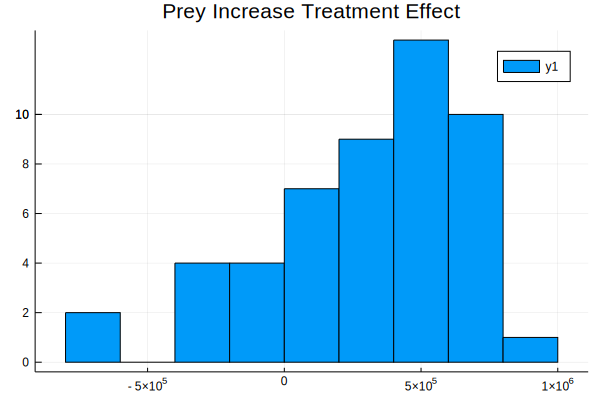

In [23]:
function increase_prey()
    
    ## New seed each run
    Random.seed!(rand(1:10000))
    ## Run normal and intervened sims
    samples = rand(random_var_tuple, 1, alg = RejectionSample)
    adj_samples = rand(random_var_tuple_int, 1, alg = RejectionSample)

    # extract run results for prey
    prey_norm_vals = []
    prey_adj_vals = []
    for x in 1:(N-1)
        push!(prey_norm_vals,samples[1][N+x])
        push!(prey_adj_vals,adj_samples[1][(N*2)+x])
    end
    
    ## Calculate difference in total prey
    return sum(prey_adj_vals) - sum(prey_norm_vals)
end

check = [increase_prey() for x=1:50]

histogram(check, bins = 10,
        title = "Prey Increase Treatment Effect")